Оценить возраст человека по изображению.

Cоздадим датафрейм содержащий относительный путь к изображению и возраст. 

In [1]:
import os
import sys
import wget
import shutil
import tarfile

import re
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

DATA_URL = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'
DATA_FILE = 'wiki_crop.tar'
DATA_FOLDER = 'wiki_crop'

print('OpenCV version ' + cv2.__version__)

OpenCV version 4.7.0


In [2]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


Загрузим файл с данными по ссылке (если файл не найден на диске)

In [3]:
def bar_custom(current, total, width=80):
    progress_msg = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write('\r' + progress_msg)
    sys.stdout.flush()

if not os.path.exists(DATA_FILE):
    wget.download(DATA_URL, DATA_FILE, bar=bar_custom)

Распакуем архив с набором данных в текущий каталог,
если каталог с данными еще не существует.

In [4]:
if not os.path.exists(DATA_FOLDER):
    tar = tarfile.open(DATA_FILE, 'r')
    tar.extractall()
    tar.close()

Выполним загрузку, проверку и обработку набора изображений из файлов

In [5]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение и сконвертировать в монохромное
                img = Image.open(source_file_path).convert('L')
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 128:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    img_bad_faces+=1
                    continue  

               
    
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 
                
                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects1[0]
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.Resampling.BILINEAR)    

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                #cropped_images = cropped_images.append({'file_path': cropped_file_path, 'label': label}, ignore_index=True)
                cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': cropped_file_path, 'label': label}])], ignore_index=True)
                img.save(cropped_file_path)
                
                
            except Exception as ex:
                #print(ex)
                img_misloaded+=1
                print(ex)
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops.csv')

 62%|██████▏   | 63/102 [03:27<02:13,  3.41s/it]

cannot identify image file 'wiki_crop\\63\\670663_2015-02-16UTC08'


100%|██████████| 102/102 [06:54<00:00,  4.06s/it]

Изображений с ошибками при загрузке 1
Изображений с некорректными размерами 40182
Изображений на которых не найдены лица 22120
Изображений c некорректной меткой класса 25
Всего корректных изображений 23656


In [6]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
# Устанавливаем seed для повторяемости результатов
numpy.random.seed(42)

In [9]:
import pandas as pd
# Укажите путь к вашему CSV файлу
csv_file_path = 'imdb_crops.csv'
# Чтение CSV файла
data = pd.read_csv(csv_file_path)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,file_path,label
0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67
1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27
2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43
3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48
4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25


In [10]:
class_counts = data['label'].value_counts()
class_counts

26    889
24    872
27    865
25    852
28    838
     ... 
1       2
96      2
3       1
5       1
4       1
Name: label, Length: 99, dtype: int64

<AxesSubplot:>

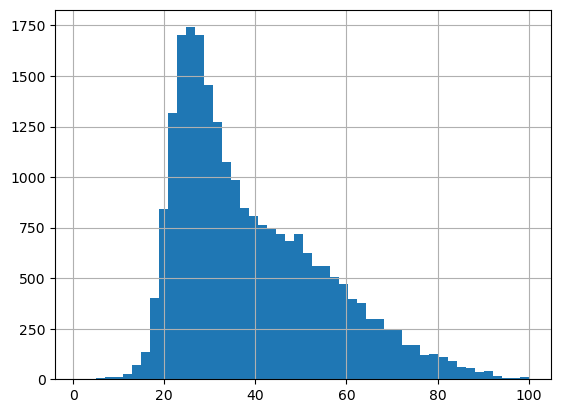

In [11]:
data['label'].hist(bins=50)

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Загрузка и предобработка данных
data = pd.read_csv('imdb_crops.csv')

# Создание категорий возрастов
age_bins = [0, 21, 24, 28, 33, 40, 47, 53, 60, 68, 100]
age_labels = list(range(len(age_bins) - 1))
data['category'] = pd.cut(data['label'], bins=age_bins, labels=age_labels)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,file_path,label,category
0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67,8
1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27,2
2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43,5
3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48,6
4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25,2


In [13]:
# Подсчет количества изображений в каждой категории
category_counts = data['category'].value_counts()

print(category_counts)

2    3444
3    3292
4    3160
5    2568
1    2432
0    2097
6    1989
7    1802
9    1503
8    1369
Name: category, dtype: int64


<AxesSubplot:>

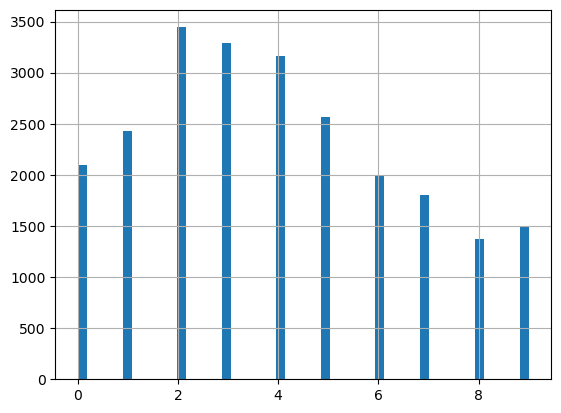

In [14]:
data['category'].hist(bins=50)

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Подготовьте метки классов
label_encoder = LabelEncoder()
data['category_encoded'] = label_encoder.fit_transform(data['category'])

# Преобразуйте метки в one-hot кодировку
labels_one_hot = to_categorical(data['category_encoded'])

# Проверка размера массива one-hot кодированных меток
print("Размер массива one-hot меток:", labels_one_hot.shape)

Размер массива one-hot меток: (23656, 10)


In [16]:
labels_one_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
# Разделите данные на массив признаков X и массив меток y
X = data['file_path']  # Здесь вам нужно использовать пути к изображениям или загрузить изображения с помощью какой-то библиотеки
y = labels_one_hot

In [18]:
from sklearn.model_selection import train_test_split
# Разделите данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка размеров массивов
print("Размер массива X_train:", X_train.shape)
print("Размер массива X_test:", X_test.shape)
print("Размер массива y_train:", y_train.shape)
print("Размер массива y_test:", y_test.shape)

Размер массива X_train: (18924,)
Размер массива X_test: (4732,)
Размер массива y_train: (18924, 10)
Размер массива y_test: (4732, 10)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Предобработка и загрузка изображений
def preprocess_images(X_train):
    images = []  # Создание пустого списка для хранения изображений
    for path in X_train:
        img = load_img(path, target_size=(64, 64))  # Загрузка изображения и изменение размера
        img_array = img_to_array(img)  # Преобразование в массив
        img_array = preprocess_input(img_array)  # Предобработка
        images.append(img_array)  # Добавление предобработанного изображения в список
    return np.array(images)

In [20]:
#Доступ к предобработанным изображениям через переменную 
X_train_images = preprocess_images(X_train)
X_test_images = preprocess_images(X_test)

In [21]:
img_size = (64, 64)
# Создание генераторов
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest', 
                                   rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator = train_datagen.flow(
    x=X_train_images,
    y=y_train,
    batch_size=batch_size
)

test_generator = test_datagen.flow(
    x=X_test_images,
    y=y_test,
    batch_size=batch_size
)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# № 1 Создание модели
model = Sequential()

# Слои свертки и пулинга
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Полносвязные слои
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))  # Количество классов возрастных категорий

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод информации о модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [26]:
# Обучение модели
history = model.fit_generator(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
592/592 [==============================] - 57s 96ms/step - loss: 2.2591 - accuracy: 0.1456 - val_loss: 2.2572 - val_accuracy: 0.1452
Epoch 2/10
592/592 [==============================] - 56s 94ms/step - loss: 2.2587 - accuracy: 0.1454 - val_loss: 2.2574 - val_accuracy: 0.1452
Epoch 3/10
592/592 [==============================] - 58s 99ms/step - loss: 2.2588 - accuracy: 0.1462 - val_loss: 2.2573 - val_accuracy: 0.1452
Epoch 4/10
592/592 [==============================] - 57s 97ms/step - loss: 2.2589 - accuracy: 0.1429 - val_loss: 2.2578 - val_accuracy: 0.1452
Epoch 5/10
592/592 [==============================] - 57s 96ms/step - loss: 2.2590 - accuracy: 0.1458 - val_loss: 2.2573 - val_accuracy: 0.1452
Epoch 6/10
592/592 [==============================] - 57s 96ms/step - loss: 2.2590 - accuracy: 0.1454 - val_loss: 2.2571 - val_accuracy: 0.1452
Epoch 7/10
592/592 [==============================] - 57s 96ms/step - loss: 2.2589 - accuracy: 0.1461 - val_loss: 2.2571 - val_accuracy:

<AxesSubplot:>

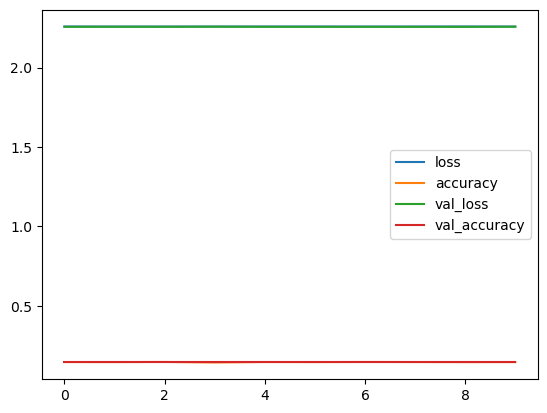

In [27]:
pd.DataFrame(history.history).plot()

In [238]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Создаем последовательную модель
model = Sequential()

model.add(Conv2D(75, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(100, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [126]:
# Создаем последовательную модель
model = Sequential()

model.add(Conv2D(75, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(100, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))